In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

# Airfoil Generation

In [2]:
# airfoil specification
wing_airfoil = asb.Airfoil("s1223")

In [3]:
# defining the full 3d geometry to analyze
# units are meters and degrees
wing = asb.Airplane(
    name="Test",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # if true, then it will be mirrored along xz-plane
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # root (middle of final produced graph but actually the first edge in this def because we are mirroring
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    # 0,0,0 = this is the wing's leading edge
                    chord=0.2, # chord length (should be in meters)
                    twist=2,  # degrees of wing twist
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0.04, 0.5, 0],
                    chord=0.2,
                    twist=0,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.1,
                    twist=-2,
                    airfoil=wing_airfoil,
                ),
            ]
        )
    ]
)

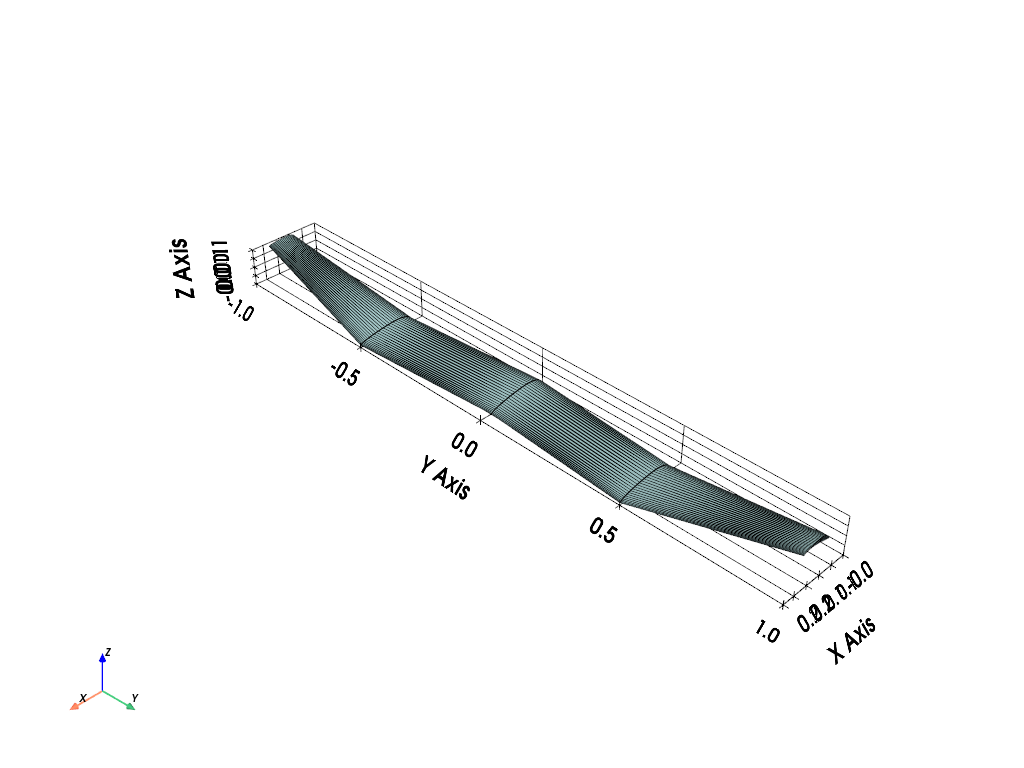

PolyData,Information
N Cells,436
N Points,438
N Strips,0
X Bounds,"-9.093e-06, 2.400e-01"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"-6.980e-03, 1.144e-01"
N Arrays,0


In [4]:
wing.draw(show_kwargs=dict(jupyter_backend="static"))

# Implementing Vortex Lattice Method

In [5]:


vlm = asb.VortexLatticeMethod(
    airplane=wing, # we don't have an airplane

    # can we vary this operating point?
    op_point=asb.OperatingPoint(
        velocity=13.4,  # m/s, about 30 mph
        alpha=5,  # angle of attack, degrees
    )
)

In [6]:
aero = vlm.run()  # Returns a dictionary that's absolutely awful to look at
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")

 F_g : [-2.68164671e+00  2.46417470e-15  5.97148195e+01]
 F_b : (2.681646714497337, 2.4641746976250545e-15, -59.71481947577096)
 F_w : (-2.5330472053157456, 2.4641746976250545e-15, -59.72130747045757)
 M_g : [ 1.02053782e-14 -7.29668553e+00  3.76434994e-16]
 M_b : (-1.0205378209171556e-14, -7.296685534458781, -3.7643499428696714e-16)
 M_w : (-1.0199352135521028e-14, -7.296685534458781, 5.144547723562393e-16)
   L : 59.72130747045757
   D : 2.5330472053157456
   Y : 2.4641746976250545e-15
 l_b : -1.0205378209171556e-14
 m_b : -7.296685534458781
 n_b : -3.7643499428696714e-16
  CL : 1.5384154304257216
  CD : 0.06525106484954586
  CY : 6.347691533656197e-17
  Cl : -1.3015551859267066e-16
  Cm : -1.0399652146354723
  Cn : -4.800908980895722e-18


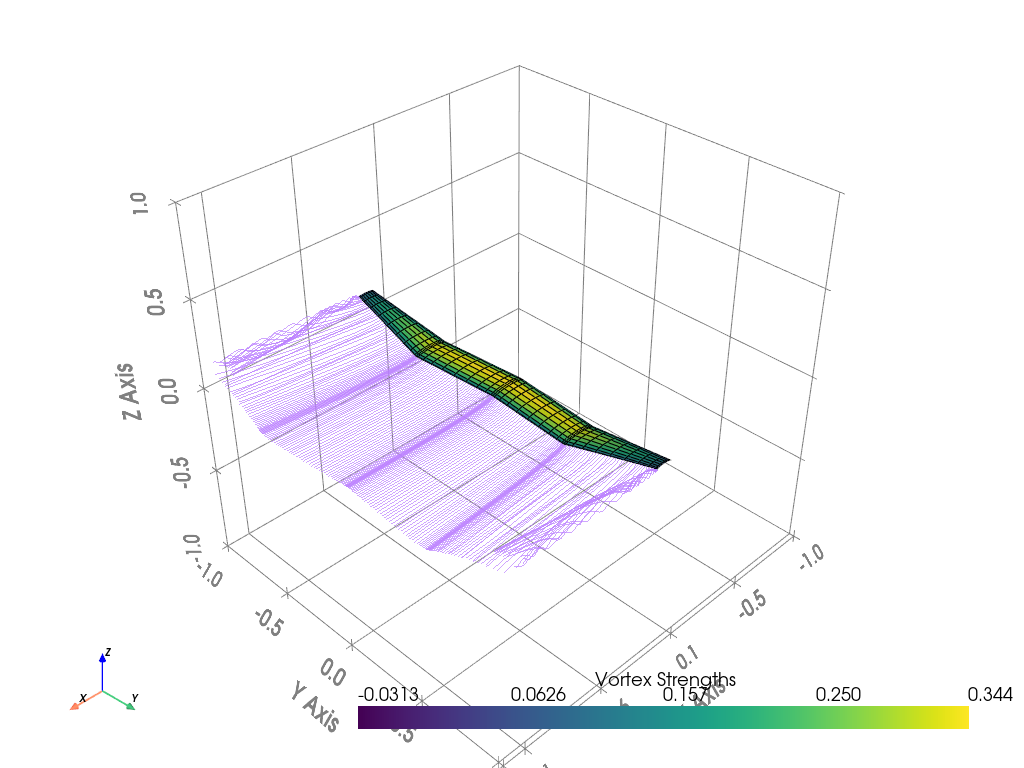

In [7]:
# nice pictures to look at
vlm.draw(show_kwargs=dict(jupyter_backend="static")) # use notebook backend

# Operating Point Optimization

In [8]:
lift_over_drag = aero['CL']/aero['CD']
print("L/D: ", lift_over_drag)

L/D:  23.576863212469533


In [9]:
opti = asb.Opti() # initialize optimizer

alpha = opti.variable(init_guess=5)

vlm = asb.VortexLatticeMethod(
    airplane=wing,
    op_point=asb.OperatingPoint(
        velocity=13.4,
        alpha=alpha
    ),
    align_trailing_vortices_with_wind=False,
)

aero = vlm.run()

L_over_D = aero["CL"] / aero["CD"]

opti.minimize(-L_over_D)
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -2.3576863e+01 0.00e+00 6.83e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [10]:
optimal_alpha = sol(alpha)
print(f"Alpha for max L/D: {optimal_alpha:.3f} deg")

Alpha for max L/D: -10.469 deg


Total solve time for optimal alpha was 2.44s.

# Aero shape optimization
### Finding the minimum induced drag.

In [11]:
opti = asb.Opti()  # Initialize an optimization environment.

N = 16  # Number of chord sections to optimize

# The y-locations (i.e. span locations) of each section. Note that the span is fixed.
section_y = np.sinspace(0, 1, N, reverse_spacing=True)
# Using `sinspace` gives us better resolution near the wing tip.

In [12]:
# going to optimize chord length, initially guess all chords = 1
chords = opti.variable(init_guess=np.ones(N)) # All chords initially guessed as "1".

wing = asb.Wing(
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                -0.25 * chords[i], # This keeps the quarter-chord-line straight.
                section_y[i], # Our (known) span locations for each section.
                0
            ],
            chord=chords[i], # all 1s initially, this is not a number but an element of type MX to optimize
            airfoil=wing_airfoil
        )
        for i in range(N) # looping through number of chord sections to optimize
    ]
)

airplane = asb.Airplane( # airplane is just a class that contains wings
    wings=[
        wing
    ]
)


In [13]:
# show an example of what the first iteration wing will look like
# can't draw from the code directly above because the actual wing components are of type MX
# which is a data type CasADi uses to numerically optimize rather than something that is drawable by aerosandbox
example_wing = asb.Wing(
    name='Main Wing',
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le = [0,0,0],
            chord = 1, # our first initial guess
            airfoil=wing_airfoil
        ),

        asb.WingXSec(
            xyz_le = [0,0.5,0],
            chord = 1, # our first initial guess
            airfoil=wing_airfoil
        ),
    ]
)

example_airplane = asb.Airplane(wings=[example_wing])


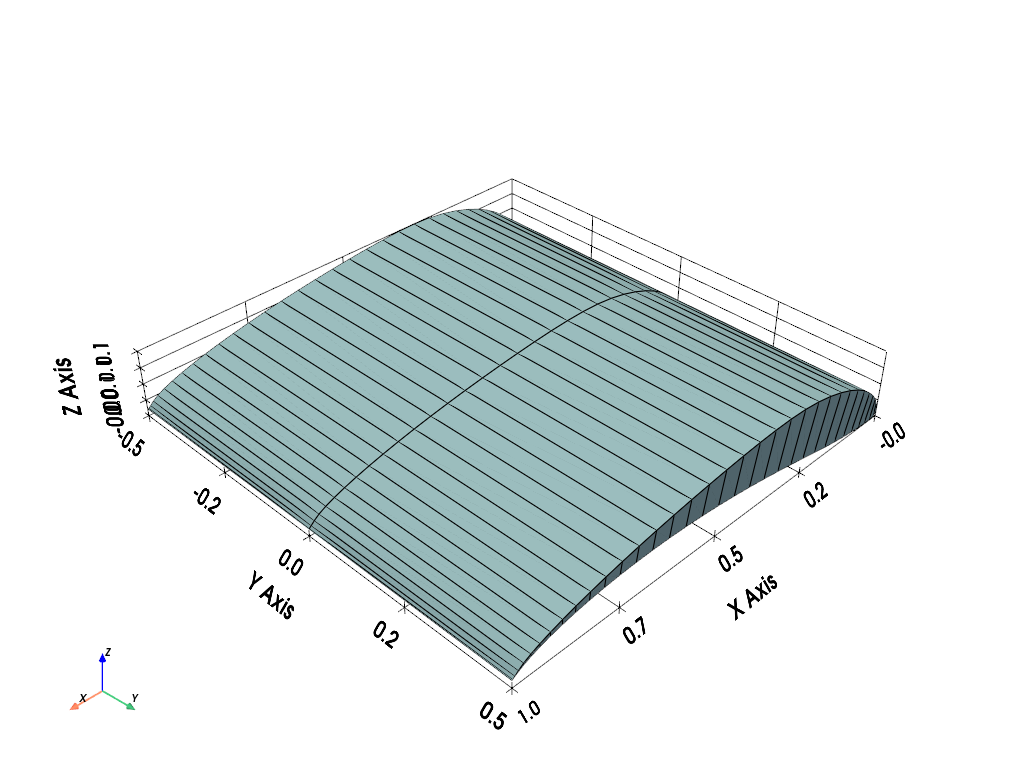

PolyData,Information
N Cells,290
N Points,292
N Strips,0
X Bounds,"-2.000e-05, 1.000e+00"
Y Bounds,"-5.000e-01, 5.000e-01"
Z Bounds,"-1.568e-02, 1.353e-01"
N Arrays,0


In [14]:
# initial guess is kinda this vibe but 16 panels instead of 2
example_airplane.draw(show_kwargs=dict(jupyter_backend="static"))

In [15]:
# adding constraints to what chord values can be (always positive) and fixed wing area
opti.subject_to([
    chords > 0,  
    wing.area() == 0.25, 
])

[MX(fabs(opti1_lam_g_1)), MX(fabs(opti1_lam_g_2))]

In [16]:
# tapering? added constraint to make solving easier apparently
opti.subject_to(
    np.diff(chords) <= 0 # The change in chord from one section to the next should be negative.
)

MX(fabs(opti1_lam_g_3))

In [17]:
alpha = opti.variable(init_guess=5, lower_bound=0, upper_bound=30) # also optimizing for angle of attack

# here is where we would specify how our operating point is going to vary
# e.g., if we are going to sweep alpha, change reynold's numbers, etc.
op_point = asb.OperatingPoint(
    velocity=13.4, # fixed velocity (does not matter, this is nondimensional)
    alpha=alpha
)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=op_point,
    spanwise_resolution=1,
    chordwise_resolution=8,
)

aero = vlm.run()

In [19]:
# hold CL constant (since we are optimizing drag)
opti.subject_to(
    aero["CL"] == 1
)

opti.minimize(aero["CD"])

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       33
Number of nonzeros in inequality constraint Jacobian.:       48
Number of nonzeros in Lagrangian Hessian.............:      153

Total number of variables............................:       17
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:       33
        inequality constraints with only lower bounds:       17
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       16

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9988005e-01 1.75e+00 5.70e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

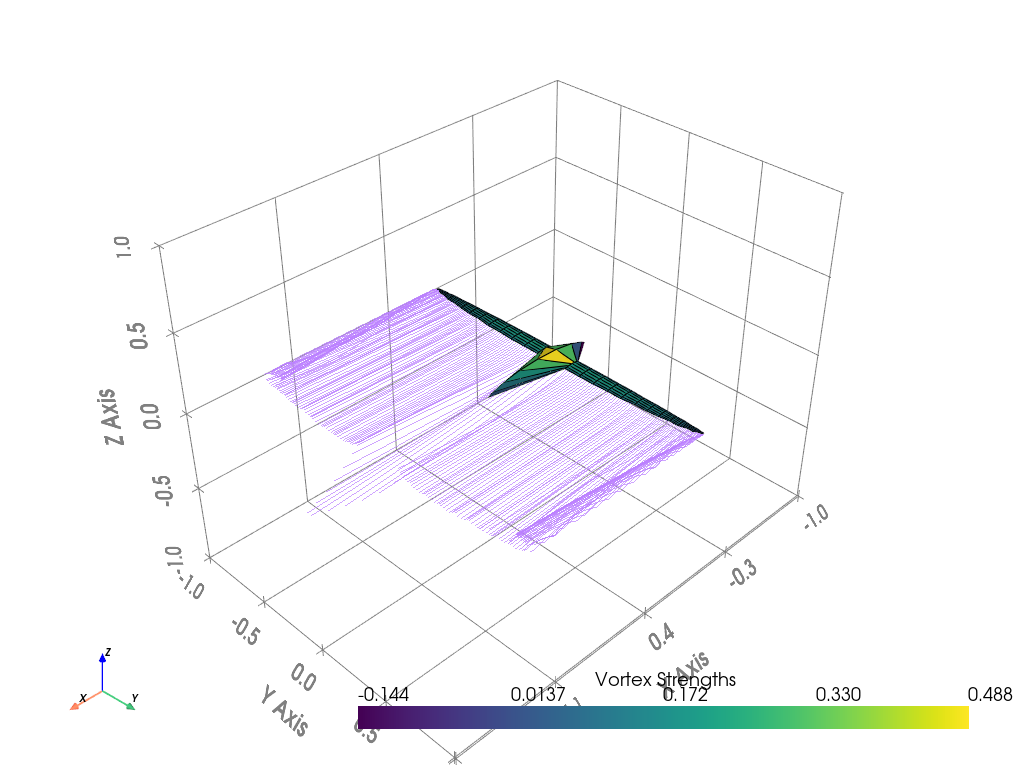

In [20]:
vlm = sol(vlm)

vlm.draw(show_kwargs=dict(jupyter_backend="static"))

### So this is supposed to be the optimized wing. Pretty weird looking, I have to say.

In [21]:
print(sol(aero['CD'])) # optimized drag coefficient

0.01700638483675236


In [22]:
for k,v in sol(aero).items():
    print("{}: {}".format(k, v))
    print()

F_g: [-4.91934071e-01 -9.94104972e-16  2.74946812e+01]

F_b: (0.49193407114012033, -9.94104971951959e-16, -27.49468118401614)

F_w: (-0.4675923546799399, -9.94104971951959e-16, -27.49510592688969)

M_g: [ 2.38399795e-15 -1.07853148e+00 -1.31418856e-16]

M_b: (-2.3839979469697514e-15, -1.0785314839151219, 1.314188558323992e-16)

M_w: (-2.3779617541568794e-15, -1.0785314839151219, 2.1451112463325455e-16)

L: 27.49510592688969

D: 0.4675923546799399

Y: -9.94104971951959e-16

l_b: -2.3839979469697514e-15

m_b: -1.0785314839151219

n_b: 1.314188558323992e-16

CL: 0.9999999953806277

CD: 0.01700638483675236

CY: -3.6155706037400724e-17

Cl: -4.3353132413752094e-17

Cm: -0.15747642203692613

Cn: 2.3898590457293248e-18



In [23]:
sol(aero['CD'])/sol(aero['CL'])

0.017006384915311184